## Latex Commands

$$
\newcommand{\F}{\mathbb{F}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\a}{\mathbf{a}}
\newcommand{\b}{\mathbf{b}}
\newcommand{\c}{\mathbf{c}}
\newcommand{\e}{\mathbf{e}}
\newcommand{\u}{\mathbf{u}}
\newcommand{\v}{\mathbf{v}}
\newcommand{\w}{\mathbf{w}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\A}{\mathbf{A}}
\newcommand{\B}{\mathbf{B}}
\newcommand{\C}{\mathbf{C}}
\newcommand{\rank}{\textbf{rank}}
\newcommand{\0}{\mathbf{0}}
\newcommand{\1}{\mathbf{1}}
\newcommand{\U}{\mathrm{U}}
\newcommand{\V}{\mathrm{V}}
\newcommand{\W}{\mathrm{W}}
\newcommand{\L}{\mathcal{L}}
$$

## Import Dependencies

In [1]:
import random
import sqlite3
from dataclasses import asdict, dataclass, field
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr, spearmanr
from sklearn import decomposition, ensemble, manifold, preprocessing

## Configuration

### Config Class

As we set attributes along the way, we can dump it into a `json` or `dict` for our training.

As an example, I know we will need to subset `predictor_cols` while training, but as of now, we do not know if we are dropping any columns or not, so I leave it as `None` and we can `setattr()` after we figured out which columns we want. One can find more in the Utilities section where I defined `set_dataclass_attr()`.

In [2]:
@dataclass
class config:
    # raw_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/aiap-coronary-artery-disease/data/raw/survive.db"
    raw_data: str = "https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/aiap-coronary-artery-disease/data/raw/survive.csv"
    processed_data: str = ""
    X_test_path: str = "data/X_test.csv"
    y_test_path: str = "data/y_test.csv"
    model_results_df_path: str = "data/model_results_df.csv"

    seed: int = 1992
    classification_type: str = "binary"
    classifiers = [  # ensemble
        ensemble.RandomForestClassifier(n_estimators=10, random_state=1992)
    ]

    cv_params: Dict[str, Any] = field(
        default_factory=lambda: {
            "cv_schema": "StratifiedGroupKFold",
            "num_folds": 6,
            "train_size": 0.9,
            "shuffle": True,
            "group_kfold_split": "ID",
            "seed": 1992,
        }
    )
    nominal_feats: List[str] = None
    ordinal_feats: List[str] = None
    categorical_feats: List[str] = None
    continuous_feats: List[str] = None

    target_col: str = "Survive"
    predictor_cols: List[str] = None
    unwanted_cols: List[str] = None

    # metrics
    monitored_metric: str = "multiclass_roc_auc_score"

    # Plotting
    target_colors: List[str] = field(
        default_factory=lambda: ["#fe4a49", "#59981A"]
    )
    cmap_reversed = plt.cm.get_cmap("mako_r")

    def to_dict(self) -> Dict[str, Any]:
        """Convert the config object to a dictionary.

        Returns:
            Dict: The config object as a dictionary.
        """

        return asdict(self)

    def to_yaml(self, filepath: Union[str, Path]) -> str:
        """Convert the config object to a YAML string and write to file.

        Args:
            filepath (Union[str, Path]): The filepath to write the YAML string to.

        Returns:
            str: The config object as YAML string.
        """
        return yaml.dump(self.to_dict(), filepath)

In [3]:
config = config() 

## Utilities

Here we store some utility functions (a.k.a helper functions).

### Seeding (Controlling Randomness)

As usual, seeding indicates reproducibility and is very important. Non-deterministic runs render your work unreliable.

- https://scikit-learn.org/stable/common_pitfalls.html#randomness

In [4]:
def seed_all(seed: int = 1992) -> None:
    """Seed all random number generators."""
    print(f"Using Seed Number {seed}")
    # set PYTHONHASHSEED env var at fixed value
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)  # for numpy pseudo-random generator
    # set fixed value for python built-in pseudo-random generator
    random.seed(seed)

### Set Attribute

In [5]:
def set_dataclass_attr(
    config: dataclass, field_name: Any, field_value: Any
) -> None:
    """Set the value of a dataclass attribute.

    This is convenient as it allows you set None to an attribute and update it later.
    
    Note that attribute can be created if it does not exist!

    Args:
        config (dataclass): Config class to set the attribute.
        field_name (Any): The name of the attribute to set.
        field_value (Any): The value of the attribute to set.

    Example:
        >>> config = Config()
        >>> config.target_col = None # originally in dataclass
        >>> set_dataclass_attr(config, "target_col", "Diagnosis")
    """
    
    setattr(config, field_name, field_value)

### Dataframe to Markdown

You must put the `print` if not won't render properly.

```
print(value_counts_df(df, "Survive").reset_index().to_markdown())
```

In [6]:
def df_to_markdown(df: pd.DataFrame, *args, **kwargs) -> str:
    """Convert a pandas DataFrame to a markdown table.

    Args:
        df (pd.DataFrame): The DataFrame to convert.

    Returns:
        str: The markdown table.
    """

    print(df.to_markdown(*args, **kwargs))

## Stage 1: Clarifying the Problem and Constraints

### General Steps

This is something that Kaggle competitions won't teach you. And this is coming from someone who loves Kaggle to bits. I slowly recognize the importance of this, especially in industry. Assume this is a real business problem, I would imagine me asking the following:

- Understand the problem at hand. What is this problem trying to solve? Although not a medical (domain) expert, but I'd reckon there's no harm reading up on the background of this on google (i.e. what is Coronary Disease?)
- Although we are given a **dependent variable** already, this may not be the case in the real world, correctly identifying the **target** may not be as easy as it seems.
- Model interpretability vs performance.

Read more from [here](https://www.acethedatascienceinterview.com/).

### Framing the Problem

At this stage we should probably know if we are dealing with a classification, regression or time-series problem. We can give a brief one here, of course, not all problems are black-and-white and some can involve an almagamation of both or more.

See my notebook on breast cancer.

## Stage 2: Establishing Metrics 

After understanding the problem better, we should probably define a metric to optimize. As usual, this step should be closely tied to business problem.

Recall that we wish to have a well-calibrated model, the intuition is that a high performance model may not output meaningful probabilities, even if they can have super good score.

Consider a model that outputs logits of $0.51$ when y_true is 1 and $0.49$ otherwise, then a decision threshold of $0.5$ guarantees an accuracy of $100\%$, we have no complaints here if we have no issue with our threshold if our only goal is to have a high scoring model. However, if in medical case, where doctor wants to understand "probablistically" the survival of a patient, then we might want to turn into logits probs. But apparently the example here holds almost no meaning, when compared to a "well calibrated model", more concretely.

```python
y_true = [0, 0, 1, 1]
y_prob_uncalibrated = [0.49, 0.49, 0.51, 0.51]
y_prob_calibrated = [0.1, 0.45, 0.99, 0.6]
```

both models give $100\%$ accuracy, but the latter (assuming calibrated), can give us a laymen idea that ok this patient has 0.99 chance and the other patient 0.6 chance of surviving etc.

### Common Pitfalls of Accuracy

**Disclaimer: For a more detailed understanding of different metrics, do navigate to my self-made notes on metrics [here](https://ghnreigns.github.io/reighns-ml-website/metrics/classification_metrics/classification_metrics/).**

---

Choosing a metric to measure the classifier's (hypothesis) performance is important, as choosing the wrong one can lead to disastrous interpretations. One prime example is using the accuracy metric for imbalanced datasets; consider 1 mil data points, dichotomized by $99\%$ benign and $1\%$ malignant samples, even a baseline model zeroR model which predicts the majority class no matter the process will give a $99\%$ accuracy, completely missing out any positive samples, which unfortunately, is what we may be more interested in.

---

<div class="alert alert-block alert-danger">
<b>Say No to Accuracy:</b> Consider an imbalanced set, where the training data set has 100 patients (data points), and the ground truth is 90 patients are of class = 0, which means that these patients do not have cancer, whereas the remaining 10 patients are in class 1, where they do have cancer. This is an example of class imbalance where the ratio of class 1 to class 0 is 1:9.
</div>   
    
Consider **a baseline (almost trivial) classifier**:

```python
def zeroR(patient_data):
        training...
    return benign
```
        

where we predict the patient's class as the most frequent class. Meaning, the most frequent class in this question is the class = 0, where patients do not have cancer, so we just assign this class to everyone in this set. By doing this, we will inevitably achieve a **in-sample** accuracy rate of $\frac{90}{100} = 90\%$. But unfortunately, this supposedly high accuracy value is completely useless, because this classifier did not label any of the cancer patients correctly.

The consequence can be serious, assuming the test set has the same distribution as our training set, where if we have a test set of 1000 patients, there are 900 negative and 100 positive. Our model just literally predict every one of them as benign, yielding a $90\%$ **out-of-sample** accuracy.

What did we conclude? Well, for one, our `accuracy` can be 90% high and looks good to the laymen, but it failed to predict the most important class of people - yes, misclassifying true cancer patients as healthy people is very bad! 

---

For the reasons mentioned above, we will use metric that can help us reduce False Negatives, and at the same time, outputs meaningful predictions. In order to achieve for both, we will use **Receiver operating characteristic (ROC)** as the primary metric for the model to maximize (which is our $\mathcal{M}$, and **Brier Score**, a [proper scoring rule](https://en.wikipedia.org/wiki/Scoring_rule) to measure the performance of our probabilistic predictions. We will go into some details in the next two subsections to justify our choice.

### Proper Scoring Rule

The math behind the idea of Proper Scoring Rule is non-trivial. Here, we try to understand why a proper scoring rule is desired in the context of binary classification.

---

<div class="alert alert-success" role="alert">
<li> <b>Strictly Proper Scoring Rule:</b> Brier Score Loss, for example, tells us that the best possible score, 0 (lowest loss), is obtained if and only if, the probability prediction we get for a sample, is the true probability itself. In other words, if a selected sample is of class 1, our prediction for this must be 1, with 100% probability, in order to get a score loss of 0.
    
<li> <b>Proper Scoring Rule:</b> Read [here](https://stats.stackexchange.com/questions/339919/what-does-it-mean-that-auc-is-a-semi-proper-scoring-rule) for this.
    
<li> <b>Semi Proper Scoring Rule:</b> AUROC, as mentioned, does not help out in telling whether a prediction by a classifier is close to the true probability or not. In our example, we even see that we can obtain a full score of 1, even if the probabilities all lie within 0.51 and 0.52.

<li> <b>Improper Scoring Rule:</b> Accuracy is a prime example, the accuracy score does not, whatsoever, tells us about how close our predicted probabilities are, to the true probability distribution of our samples.
</div>

### Defining the Metrics

#### Receiver operating characteristic (ROC)

<div class="alert alert-success" role="alert">
    <b>Definition:</b> The basic (non-probablistic intepretation) of ROC is graph that plots the True Positive Rate on the y-axis and False Positive Rate on the x-axis parametrized by a threshold vector $\vec{t}$. We then look at the area under the ROC curve (AUROC) to get an overall performance measure.
</div>

---

The choice of ROC over other metrics such as Accuracy is detailed initially. **We also established we want to reduce False Negative (FN), since misclassifying a positive patient as benign is way more costly than the other way round.** One can choose to minimize **Recall** in order to reduce FN, but this is less than ideal during training because it is a thresholded metric, and does not provide at which threshold the recall is at minimum. This leads us to choose ROC for the following two main reasons:

##### Threshold Invariant

By definition, ROC computes the pair $TPR \times FPR$ over all thresholds $t$, consequently, the AUROC is threshold invariant, allowing us to look at the model's performance over all thresholds. We note that ROC may not be that reliable in the case of very imbalanced datasets where majority is in the negative class, as $FPR = \dfrac{FP}{FP+TN}$ may seem deceptively low as denominator may be made small by the sheer amount of TN, in this case, we may also look at the Precision-Recall curve.

##### Scale Invariant

Technically, this is not the desired property that we need, as this means that the ROC is non-proper in scoring, it can take in non-calibrated scores and still perform relatively well. A classic example I always use is the following:

```python
y1 = [1,0,1,0]
y2 = [0.52,0.51,0.52,0.51]
y3 = [52,51,52,51]
y4 = [0.99, 0.51, 0.98, 0.51]
uncalibrated_roc = roc(y1,y2) == roc(y1,y3) == roc(y1, y4)
print(f"{uncalibrated_roc}") -> 1.0
```

The example tells us two things, as long as the ranking of predictions is preserved, the final AUROC score is the same, regardless of scale. We also notice that even though the model gives very unconfident predictions, the AUROC score is 1, which can be misleadingly over-optimistic. With that, we introduce Brier Score.

##### Caution on using ROC from Scikit-learn

<div class="alert alert-block alert-danger">
<b>Careful when using ROC function!</b>   
    
We also note that when passing arguments to scikit-learn's <code>roc_auc_score</code> function, we should be careful not to pass <code>y_score=model.predict(X)</code> inside as we have to understand that we are passing in <b>non-thresholded</b> probabilities into <code>y_score</code>. If you pass the predicted values (full of 0 and 1s), then you are thresholding on 0 and 1 only, which is incorrect by definition. 
</div>

#### Brier Score

<div class="alert alert-success" role="alert">
    <b>Definition:</b> Brier Score computes the squared difference between the probability of a prediction and its actual outcome. 
</div>

---

[Brier Score](https://en.wikipedia.org/wiki/Brier_score) is a strictly proper scoring rule while ROC is [not](https://www.fharrell.com/post/class-damage/); the lower the Brier Score, the better the predictions are calibrated. We can first compute the AUROC score of the model, and compute Brier Score to give us how well calibrated (confident) the predictions are.

##### Well Calibrated

A intuitive way of understanding well calibrated probabilities is as follows, extracted from [cambridge's probability calibration](https://blog.cambridgespark.com/probability-calibration-c7252ac123f):

> In very simple terms, these are probabilities which can be interpreted as a confidence interval. Furthermore, a classifier is said to produce well calibrated probabilities if for the instances (data points) receiving probability 0.5, 50% of those instances belongs to the positive class.

---

In my own words, if a classifier is well calibrated, say in our context where we predict binary target, and pretend that out of our test set, 100 of the samples have a probability of around 0.1, then this means 10% of these 100 samples actually belong to the positive class.

The generic steps are as follows to calculate a calibrated plot:

1. Sort all the samples by the classifier's predicted probabilities, in either ascending or descending order.
2. Bin your diagram into N bins, usually we take 10, which means on the X-axis, note this does not mean we have 0-0.1, 0.1-0.2, ..., 0.9-1 as the 10 bins.
3. What step 2 means is let's say you have 100 predictions, if you bin by 10 bins, and since the predictions are ***sorted***, we can easily divide the 100 predictions into 10 intervals: for illustration, assume the 100 predictions are as follows, where we sort by ascending order and the prediction 0.1 has 10 of them, 0.2 have 10 of them, so on and so forth.
    ```python
    y_pred = [0.1, 0.1, ....., 0.2, 0.2, ..., 0.9, 0.9, ..., 1, 1, ...1]
    ```
4. Since we can divide the above into 10 bins, bin 1 will have 10 samples of predictions 0.1, bin 2 will have 10 samples of predictions 0.2, etc. We then take the mean of the **predictions of each bin**, that is for the first bin, we calculate $\dfrac{1}{10}\sum_{i=1}^{10}0.1 = 0.1$, and second bin, $\dfrac{1}{10}\sum_{i=1}^{10}0.2 = 0.2$. Note that this may not be such a nice number in reality, I made this example for the ease of illustration!
5. Now, we have our X-axis from step 4, that is, we turned 10 bins, into 10 numbers, 0.1, 0.2, 0.3, ..., 1, and then we need to find the corresponding points for each of the 10 numbers! This is easy, for 0.1, the corresponding y-axis is just the **fraction of positives**, which means, out of the 10 samples in the first bin, how many of these 10 samples were actually positive? We do this for all 10 bins (points), and plot a line graph as seen in scikit-learn.  

---

Now this should be apparent now that a well calibrated model should lie close to the $y = x$ line. That is, if the mean predicted probability is 0.1, then the y-axis should also be 0.1, meaning to say that out of all the samples that were predicted as 0.1, we should really only have about 10% of them being positive. The same logic applies to the rest!

---

##### Brier Score Loss

Brier Score Loss is a handy metric to measure whether a classifier is well calibrated, as quoted from [scikit-learn](https://scikit-learn.org/stable/modules/calibration.html):

> Brier Score Loss may be used to assess how well a classifier is calibrated. However, this metric should be used with care because a lower Brier score does not always mean a better calibrated model. This is because the Brier score metric is a combination of calibration loss and refinement loss. Calibration loss is defined as the mean squared deviation from empirical probabilities derived from the slope of ROC segments. Refinement loss can be defined as the expected optimal loss as measured by the area under the optimal cost curve. As refinement loss can change independently from calibration loss, a lower Brier score does not necessarily mean a better calibrated model.

##### Caution on Brier Score

<div class="alert alert-block alert-danger">
<b>Class Imbalance:</b> The good ol' class imbalance issue almost always pop up anywhere and everywhere. Intuitively, if we have a super rare positive/negative class, then if the model is very confident in its predictions for the majority class, but not so confident on the rare class, the overall Brier Score Loss may not be sufficient in discriminating the classifier's inability in correctly classifying the minority class.
</div>

<div class="alert alert-block alert-danger">
<b>Non-Calibrated:</b> Models such as RF does not produce natural probabilities, so may need to calibrate it first. However, scikit-learn's RF has built-in `predict_proba` and so we can use it.
</div>

### Benefit Structure

Refer to health insurance project and I briefly mentioned in my [blog here](https://ghnreigns.github.io/reighns-ml-website/metrics/classification_metrics/confusion_matrix/#benefit-structure).

## Stage 3: Preliminary Data Inspection and Cleaning

### Data Loading

This data source is in `.db` format, and herein we define a function to read such files as dataframe.

In [7]:
def read_sqlite_file(
    db_file: Union[str, Path],
    sql_query: str,
    path_to_save: Optional[Union[str, Path]] = None,
) -> pd.DataFrame:
    """Reads a sqlite database file and returns a pandas dataframe.

    Args:
        db_file (Union[str, Path]): The .db file to read.
        sql_query (str): The sql query to execute, in string. E.g. "SELECT * FROM table_name".
        path_to_save (Optional[Union[str, Path]]): The path to save the dataframe.

    Returns:
        df (pd.DataFrame): The dataframe containing the results of the query.
    """
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query(sql_query, conn)
        conn.close()
        if path_to_save is not None:
            df.to_csv(path_to_save, index=False)
        return df

    except FileNotFoundError:
        print("File not found.")
        return None

In [8]:
# BASE_PATH = Path("__file__").parent.parent.absolute()
# DATA_DIR = Path.joinpath(BASE_PATH, "data")
# survive_db_path = Path.joinpath(DATA_DIR, "survive.db")

# df = read_sqlite_file(db_file = config.raw_data, sql_query = "SELECT * FROM survive", path_to_save=None)

df = pd.read_csv(config.raw_data)

### A brief look at the dataset

We will use two simple commands from `pandas` to aid us. This is just very brief glance at the dataset.

#### First Few Rows

> We will query the first five rows of the dataframe to get a feel on the dataset we are working on. 

> The command is `df.head(5)` where $5$ is the number of rows you want to show.

The table is presented as such, why bother doing this? For one, you get a good feel of what **kinds of data you are dealing with**. The table below looks relatively clean, be surprised, however, to find weird representations when dealing with time-based columns!

|    | ID     |   Survive | Gender   | Smoke   | Diabetes     |   Age | Ejection Fraction   |   Sodium |   Creatinine |   Platelets |   Creatine phosphokinase |   Blood Pressure |   Hemoglobin |   Height |   Weight | Favorite color   |
|---:|:-------|----------:|:---------|:--------|:-------------|------:|:--------------------|---------:|-------------:|------------:|-------------------------:|-----------------:|-------------:|---------:|---------:|:-----------------|
|  0 | TIG1GE |         0 | Male     | Yes     | Normal       |    50 | Low                 |      141 |          0.7 |      266000 |                      185 |              105 |         12.3 |      180 |       93 | green            |
|  1 | VXUCV9 |         1 | Male     | No      | Normal       |    75 | Low                 |      134 |          2.5 |      224000 |                       99 |              162 |         13   |      140 |       47 | black            |
|  2 | AFH4F1 |         1 | Female   | No      | Pre-diabetes |    80 | Low                 |      135 |          1.3 |      192000 |                      776 |              179 |         12.4 |      150 |       61 | white            |
|  3 | ZK6PAC |         0 | Male     | No      | Normal       |   -60 | Low                 |      136 |          0.9 |      228000 |                     2261 |              136 |         15.3 |      130 |       48 | yellow           |
|  4 | 6CVBRT |         0 | Female   | No      | Normal       |    70 | Low                 |      141 |          0.9 |      358000 |                     1202 |              171 |         13.3 |      177 |       64 | blue             |

In [9]:
# display(df.head(5))
# df_to_markdown(df.head(5))

#### DataFrame Info

> We also call `df.info()` to see the data types of the columns, and to briefly check if there is any missing values in our data (more on that later). 

The table is presented below:

```python
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      15000 non-null  object 
 1   Survive                 15000 non-null  object 
 2   Gender                  15000 non-null  object 
 3   Smoke                   15000 non-null  object 
 4   Diabetes                15000 non-null  object 
 5   Age                     15000 non-null  int64  
 6   Ejection Fraction       15000 non-null  object 
 7   Sodium                  15000 non-null  int64  
 8   Creatinine              14501 non-null  float64
 9   Platelets               15000 non-null  float64
 10  Creatine phosphokinase  15000 non-null  int64  
 11  Blood Pressure          15000 non-null  int64  
 12  Hemoglobin              15000 non-null  float64
 13  Height                  15000 non-null  int64  
 14  Weight                  15000 non-null  int64  
 15  Favorite color          15000 non-null  object 
dtypes: float64(3), int64(6), object(7)
memory usage: 1.8+ MB
```

From this we can tell the data types and if there are missing values.

In [10]:
# df.info(verbose=True)

#### Importance of data types

We must be sharp and ensure that each column is indeed stored in their respective data types! In the real world, we may often query "dirty" data from say, the database, where numeric data are represented in string. It is now our duty to ensure sanity checks are in place! More on this later!

#### What did we find?

A brief overview tells us the following:

- There is one column `Creatinine` which has missing values. We will have to deal with it.
- As with most dataset, there is an `ID` column which usually serves as a primary key. We may drop it if we find no predictive power. **However**, even though we are likely not use it for modelling, we may use it to **split our data**. More on it later.
- Since the problem statement is about predicting whether a patient **survives** with **coronary artery disease**, then the predictor `Favorite color` looks a bit off the grid, and hence fishy. We can check if this column really contributes to the target or just random noise that we need to filter out.

### Summary Statistics and Manual Checking

#### DataFrame Description and Pandas Profiling

We will use a simple, yet powerful function call to check on the summary statistics of our dataframe. We note to the readers that there are much more powerful libraries like [pandas-profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/) to give us an even more thorough summary, but for our purpose, we will use the good ol' `df.describe()`.

---

|        | ID     |   Survive | Gender   | Smoke   | Diabetes   |        Age | Ejection Fraction   |      Sodium |   Creatinine |   Platelets |   Creatine phosphokinase |   Blood Pressure |   Hemoglobin |     Height |     Weight | Favorite color   |
|:-------|:-------|----------:|:---------|:--------|:-----------|-----------:|:--------------------|------------:|-------------:|------------:|-------------------------:|-----------------:|-------------:|-----------:|-----------:|:-----------------|
| count  | 15000  |     15000 | 15000    | 15000   | 15000      | 15000      | 15000               | 15000       |  14501       |     15000   |                15000     |       15000      |  15000       | 15000      | 15000      | 15000            |
| unique | 14042  |         4 | 2        | 4       | 3          |   nan      | 5                   |   nan       |    nan       |       nan   |                  nan     |         nan      |    nan       |   nan      |   nan      | 6                |
| top    | DADB9X |         0 | Male     | No      | Normal     |   nan      | Low                 |   nan       |    nan       |       nan   |                  nan     |         nan      |    nan       |   nan      |   nan      | blue             |
| freq   | 4      |      9581 | 9757     | 9710    | 8789       |   nan      | 12734               |   nan       |    nan       |       nan   |                  nan     |         nan      |    nan       |   nan      |   nan      | 2532             |
| mean   | nan    |       nan | nan      | nan     | nan        |    57.4285 | nan                 |   136.604   |      1.4102  |    263096   |                  580.152 |         103.677  |     12.9107  |   159.475  |    69.3405 | nan              |
| std    | nan    |       nan | nan      | nan     | nan        |    23.4112 | nan                 |     4.36489 |      1.04453 |     98056.3 |                  955.419 |          39.7001 |      2.50015 |    17.3444 |    25.2983 | nan              |
| min    | nan    |       nan | nan      | nan     | nan        |   -95      | nan                 |   113       |      0.5     |     25100   |                   23     |          40      |      9       |   130      |    19      | nan              |
| 25%    | nan    |       nan | nan      | nan     | nan        |    50      | nan                 |   134       |      0.9     |    211000   |                  115     |          70      |     10.7     |   144      |    50      | nan              |
| 50%    | nan    |       nan | nan      | nan     | nan        |    60      | nan                 |   137       |      1.1     |    262000   |                  250     |         100      |     12.7     |   160      |    66      | nan              |
| 75%    | nan    |       nan | nan      | nan     | nan        |    70      | nan                 |   140       |      1.4     |    304000   |                  582     |         137      |     15.1     |   174      |    87      | nan              |
| max    | nan    |       nan | nan      | nan     | nan        |    95      | nan                 |   148       |      9.4     |    850000   |                 7861     |         179      |     17.5     |   189      |   141      | nan              |

In [11]:
# display(df.describe(include="all"))
# df_to_markdown(df.describe(include="all"))

The table does give us a good overview: for example, a brief glance give me the following observations:

1. The features **do not seem to be of the same scale**. This is going to be a problem as some models do not perform well if your features are not on the same scale. A prime example is a KNN model with Euclidean Distance as the distance metric, the difference in range of different features will be amplified with the squared term, and the feature with wider range will dominate the one with smaller range. 

2. `ID` is not **unique**, an instant reaction is we may need `GroupKFold` later on to ensure no **data leakage**.

3. `Survive` is not **binary**? What, can someone be not **dead** and **alive**?

4. `Age` has negative values? Something is wrong.

5. `Favorite Color`? ok.

Humans are more visual and that is why we still need EDA later to capture our attention on any anomaly from the dataset, and of course, if the dataset has many columns, then this summary statistics may even clog your progress if you were to read it line by line.

#### Manual Checking

Just by the above table, we can spot so many issues. I need to check asap in a more manual way to see what is happening. The following solution isn't elegant, but sometimes getting your hands dirty is a good way to understand your data better.

Note `value_counts` should be sorted by **values** by adding `.sort_index()` so I can easily see min and max.

##### Non-Unique ID

The `ID` column is the identifier for each patient and is **non-unique**. Alternatively, the `df.describe()` also tells you so.

```python
print(f"The ID column is unique : {df['ID'].is_unique}") 
False
```

> This may suggest that there are patient records with multiple observation, which is a violation of **i.i.d** assumption and we may take note when doing cross-validation, so as to avoid information leakage.

> Thus, we will drop this column during **training** as it holds no predictive power, but keep it for **splitting** data.

In [12]:
# df.ID.is_unique

##### Negative Age

|   Age |   count |
|------:|--------:|
|    95 |      83 |
|    94 |      54 |
...
|   -40 |       9 |
|   -41 |       1 |
|   -42 |      15 |
...

The variable `Age` takes on negative values, if I have no way to ask whether this is just a negation of the positive (i..e $-45 = 45$), I will treat it as missing values as well. For now, I reassign them to `np.nan` so we indicate they are missing. 

##### Non-binary Survival

| Survive   |   count |
|:----------|--------:|
| Yes       |     263 |
| No        |     604 |
| 1         |    4552 |
| 0         |    9581 |

In [13]:
def value_counts_df(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Returns pd.value_counts() as a DataFrame:
    https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe

    Parameters
    ----------
    df : Pandas Dataframe
        Dataframe on which to run value_counts(), must have column `col`.
    col : str
        Name of column in `df` for which to generate counts

    Returns
    -------
    Pandas Dataframe
        Returned dataframe will have a single column named "count" which contains the count_values()
        for each unique value of df[col]. The index name of this dataframe is `col`.

    Example
    -------
    >>> value_counts_df(pd.DataFrame({'a':[1, 1, 2, 2, 2]}), 'a')
       count
    a
    2      3
    1      2
    """
    df = pd.DataFrame(
        df[col]
        .value_counts(
            normalize=False, sort=True, ascending=False, bins=None, dropna=True
        )
        .sort_values(ascending=False)
        .sort_index(ascending=False)
    )
    df.index.name = col
    df.columns = ["count"]
    return df

In [14]:
# problematic_cols = ["ID", "Age", "Survive", "Smoke", "Ejection Fraction", "Favorite color"]
# with pd.option_context('display.max_rows', 20,):
#     for col in problematic_cols:
#         if col == "ID": display(value_counts_df(df, col))
#         else: 
#             display(value_counts_df(df, col))
#             df_to_markdown(value_counts_df(df, col))

#### Unwanted Columns

Here we define a `drop_columns` function to drop the unwanted columns. We have our candidates in mind, but we won't drop them until later.

In [15]:
def drop_columns(df: pd.DataFrame, columns: List) -> pd.DataFrame:
    """Drop unwanted columns from dataframe.

    Args:
        df (pd.DataFrame): Dataframe to be cleaned
        columns (List): list of columns to be dropped

    Returns:
        df_copy (pd.DataFrame): Dataframe with unwanted columns dropped.
    """

    df_copy = df.copy()
    df_copy = df_copy.drop(columns=columns, axis=1, inplace=False)
    return df_copy.reset_index(drop=True)

#### Missing Data

!!! danger "Missing Alert?"
    Missing data is a perpetual problem, a brief glance just now told me that `Creatinine` has some missing values, as verified here.
    
|            |   missing num |   missing percentage (%) |
|:-----------|--------------:|-------------------------:|
| Creatinine |           499 |                  3.32667 |
| ID         |             0 |                  0       |
| Survive    |             0 |                  0       |
| Gender     |             0 |                  0       |
| Smoke      |             0 |                  0       |

> We do have to think if we want to keep them or not, in practice (ok I do not know lah~), I would've clarified from the data source if this missing values is normal, or a by-product of human errors first before doing anything!

In [16]:
def report_missing(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """A function to check for missing data.

    Args:
        df (pd.DataFrame): The DataFrame to check.
        columns (List): The columns to check.

    Returns:
        missing_data_df (pd.DataFrame): Returns a DataFrame that reports missing data.
    """
    missing_dict = {"missing num": [], "missing percentage (%)": []}
    for col in columns:
        num_missing = df[col].isnull().sum()
        percentage_missing = (num_missing / len(df)) * 100
        missing_dict["missing num"].append(num_missing)
        missing_dict["missing percentage (%)"].append(percentage_missing)

    missing_data_df = pd.DataFrame(
        index=columns, data=missing_dict
    ).sort_values(by=["missing percentage (%)"], ascending=False)

    return missing_data_df

In [17]:
# missing_df = report_missing(df, columns=df.columns)
# display(missing_df.head())
# df_to_markdown(missing_df.head())

#### What did we find?

1. The features **do not seem to be of the same scale**. This is going to be a problem as some models do not perform well if your features are not on the same scale. A prime example is a KNN model with Euclidean Distance as the distance metric, the difference in range of different features will be amplified with the squared term, and the feature with wider range will dominate the one with smaller range. 
2. `ID` is not **unique**, an instant reaction is we may need `GroupKFold` later on to ensure no **data leakage**.
3. `Survive` is not **binary**? What, can someone be not **dead** and **alive**?
4. `Age` has negative values? Something is wrong.
5. `Favorite Color`? Logic just tells me something is off here, is there something about a patients favourite color that could affect his/her chance of survival?
6. We have two unwanted columns candidates in mind, `ID` and `Favorite Color`.
7. Some missing values from `Creatinine`.

### Data Types

Data types of predictors and target are important. Many **pre-processing** depends on this. A classic example is whether to **label, integer or one-hot encode** the variables.

To check the dtypes of the variables, we use the function `check_df_dtypes()` to return us either a dataframe or a dict as follows:

|     column name                   | dtype       |
|:-----------------------|:--------|
| ID                     | object  |
| Survive                | object  |
| Gender                 | object  |
| Smoke                  | object  |
| Diabetes               | object  |
| Age                    | int64   |
| Ejection Fraction      | object  |
| Sodium                 | int64   |
| Creatinine             | float64 |
| Platelets              | float64 |
| Creatine phosphokinase | int64   |
| Blood Pressure         | int64   |
| Hemoglobin             | float64 |
| Height                 | int64   |
| Weight                 | int64   |
| Favorite color         | object  |

---

Note the `dtype` mapping.

- `object`: This variable is a **string**. ML algorithms typically do not deal well with **string** objects and we need to convert them to **numbers** (either **int** or **float** will depend on us).
- `int64`: This variable is an **integer**. Typically **categorical**.
- `float64`: This variable is a **float**. Typically **continuous**.

---

Note that real world data is noisy, what we see may not be "true". For example, our variable `Hemoglobin` is stored as a `float` and hence we would think it is a continuous variable. What can go wrong with this assumption?

> If `Hemoglobin` is actually a variable that takes on only 3 unique float values. Does it make sense then to make this variable continuous?

Also, real world data is often stored as a string, so imagine if `Hemoglobin` is stored as `object (str)`, we have to convert it to its correct data types.

---

So far, we can conclude the following (and yes I googled to get a better idea on what the medical terms signify).

In [18]:
def check_df_dtypes(df: pd.DataFrame, to_dict: bool = True) -> Dict[str, str]:
    """Check the dataframe variables data types and returns a dict.
    Args:
        df (pd.DataFrame): The dataframe to check.
        to_dict (bool): If True, returns a dict, otherwise returns a DataFrame.

    Returns:
        Dict[str, str]: The dataframe variables data types in a dict.
    """

    return (
        df.dtypes.apply(lambda x: x.name).to_dict()
        if to_dict
        else df.dtypes.apply(lambda x: x.name)
    )

In [19]:
# df_dtypes = check_df_dtypes(df, to_dict=False)
# df_to_markdown(df_dtypes)

#### Categorical Variables

##### Nominal Categorical

Nominal is categorical variables without inherent ranking. Non-ordinal categorical variables, (cat, dog, pig), no inherent ranking should be one-hot encoded (or dummy encoded if using linear models).

**So we give it a normal ordinal mapping first and later we will use encoding techniques to handle them.**
    
- `Survive`: The target variable, although represented as a string in the dataframe, should be categorical! This is because machines do not really like working with "strings" and prefer your type to be of "numbers". 

    |    | Survive   |   count |
    |---:|:----------|--------:|
    |  0 | Yes       |     263 |
    |  1 | No        |     604 |
    |  2 | 1         |    4552 |
    |  3 | 0         |    9581 |
    print(value_counts_df(df, "Survive").reset_index().to_markdown())

    - We will map **Yes** and **No** to 1 and 0 respectively according to the Dataset Description. Of course, we can use `label encoder` but I prefer to do it manually. Note this is our **target**.
    - `target_map = {"Yes": 1, "No": 0, "0": 0, "1": 1}` 
    
- `Gender`: We map **Male** and **Female** to 1 and 0 respectively. This is of course, nominal as male and female has no inherent order.
    - `gender_map = {"Female": "0", "Male": "1"}`

- `Favorite Color`: 😂😂😂😂😂😂😂😂
    - `color_map = {"yellow": 0, "white": 1, "red": 2, "green": 3, "blue": 4, "black": 5}`

##### Ordinal Categorical

Encode Feature Variables that are of ordinal, (junion -> senior -> tech lead) is an example of ordinal where there is ranking.

- `Smoke`: Ok, I googled. I do not know if **smoking status** is ordered. According to [here](https://statacumen.com/teach/S4R/PDS_book/data-architecture.html) it is ordinal and it makes sense to me.
    |    | Smoke   |   count |
    |---:|:--------|--------:|
    |  0 | Yes     |    4707 |
    |  1 | YES     |     184 |
    |  2 | No      |    9710 |
    |  3 | NO      |     399 |
    
    - Yikes, dirty labelling, let's change all **YES/Yes/YASSSS** and **NO/No/Nooooooooo** to 1 and 0 respectively.
    - `smoke_map = {"NO": 0, "No": 0, "YES": 1, "Yes": 1}`
    
- `Diabetes`: Should be ordinal as we can rank `pre -> normal -> diabetes` like `good -> oh no -> bad`.

    |    | Diabetes     |   count |
    |---:|:-------------|--------:|
    |  0 | Pre-diabetes |    3124 |
    |  1 | Normal       |    8789 |
    |  2 | Diabetes     |    3087 |
    
    - We map 0, 1 and 2 respectively using the above order.
    - `diabetes_map = {"Pre-diabetes": 0, "Normal": 1, "Diabetes": 2}`

- `Ejection Fraction`: In description, it is the strength of heart, and strength usually implies an ordering... so ordinal you go!

    |    | Ejection Fraction   |   count |
    |---:|:--------------------|--------:|
    |  0 | Normal              |    1658 |
    |  1 | N                   |      66 |
    |  2 | Low                 |   12734 |
    |  3 | L                   |     482 |
    |  4 | High                |      60 |

    - 😂😂😂😂😂😂😂😂, guessing game? I am willing to bear the consequences and say **N and L** corresponds to **Normal and Low** respectively... Well...on a more serious note, I'd have clarified with my client, host about this vague symbol meaning...
    - So let's map **Low, Normal, High** to 0, 1 and 2.
    - `ejection_map = {"Low": 0, "Normal": 1, "High": 2, "N": 1, "L": 0}`

#### Continuous Variables
    
- `Age`: Another tricky variable. Here is a good treatment on when we should treat [age as continuous or categorical](https://stats.stackexchange.com/questions/391379/should-i-treat-age-as-a-continuous-variable-or-factor).

    > For a disease: the aging process that might change our probability of getting a disease doesn't usually happen in sudden shifts, therefore, I would tend to start with a continuous variable. However, the impact of age may not be strictly linear-- being one year older might matter more if you're 39 than if you're 22. So binning may still be something you need to try, or adding the square of the age or something like that.
    
    I am not very confident in using the **binning technique** just yet. So I will treat **Age** as continuous. [^reference_on_age_cont_cat]
    
- `Sodium`: Continuous
- `Creatinine`: Continuous
- `Platelets`: Continuous
- `Blood Pressure`: Continuous
- `Hemoglobin`: Continuous
- `Height`: Continuous
- `Weight`: Continuous

[^reference_on_age_cont_cat]: https://www.kaggle.com/c/petfinder-pawpularity-score/code

#### Set Attributes of Columns to Config

In [20]:
ordinal_feats = [
    "Smoke",
    "Diabetes",
    "Ejection Fraction",
]

nominal_feats = ["Gender", "Favorite color"]

categorical_feats = [
    "Gender",
    "Smoke",
    "Diabetes",
    "Ejection Fraction",
    "Favorite color"
]
continuous_feats = [
    "Age",
    "Sodium",
    "Creatinine",
    "Platelets",
    "Creatine phosphokinase",
    "Blood Pressure",
    "Hemoglobin",
    "Height",
    "Weight",
]

In [21]:
set_dataclass_attr(config, "ordinal_feats", ordinal_feats)
set_dataclass_attr(config, "nominal_feats", nominal_feats)
set_dataclass_attr(config, "categorical_feats", categorical_feats)
set_dataclass_attr(config, "continuous_feats", continuous_feats)

#### What did we find?

We found out which variables should be categorical (nominal and ordinal) and continuous. This helps us make informed decisions later on if we need to one-hot encode the variables.

### Correct the Wrongs Part I

This is only part I of correcting the wrongs we found! There are parts we cannot just modify now, for example, what should we do to missing values?

This part is dedicated to mapping the data's columns to correct values and data types.

In [22]:
df_copy = df.copy() # make a copy in case mapping goes wrong 

In [23]:
# 1. Standardize and map messy column values. i.e. 'Yes' -> 1, 'No' -> 0
gender_map = {"Female": 0, "Male": 1}
color_map = {
    "yellow": 0,
    "white": 1,
    "red": 2,
    "green": 3,
    "blue": 4,
    "black": 5,
}
smoke_map = {"NO": 0, "No": 0, "YES": 1, "Yes": 1}
diabetes_map = {"Pre-diabetes": 0, "Normal": 1, "Diabetes": 2}
ejection_map = {"Low": 0, "Normal": 1, "High": 2, "N": 1, "L": 0}
target_map = {"Yes": 1, "No": 0, "0": 0, "1": 1}

categorical_maps = {
    "Gender": gender_map,
    "Favorite color": color_map,
    "Smoke": smoke_map,
    "Diabetes": diabetes_map,
    "Ejection Fraction": ejection_map,
    "Survive": target_map,
}

for column, column_map in categorical_maps.items():
    df[column] = df[column].map(column_map)
    # don't call this more than once as it overwrites

We check again briefly to see our mapping is successful. We will check more during EDA.

In [24]:
# df.info()

# problematic_cols = ["ID", "Age", "Survive", "Smoke", "Ejection Fraction", "Favorite color"]
# for col in problematic_cols:
#     display(value_counts_df(df, col))

### Stage 3 Summary

Here we conclude our **Stage 3** with some ending notes.

- Missing data issue is not handle yet. We merely identified there is.
- We map each variables to their respective data types with encoding. This encoding is not final as we will likely do more encoding during preprocessing. But at least we mapped the strings to numbers.
- **ID** column proved to be non-unique, this information propels us to consider using `GroupKFold` during cross-validation to avoid data leakage.
- **Age** has negative values. This issue is identified but not rectified. We merely turned all wrong values to `np.nan` for processing later.
- **Favorite color** seems to be a noisy variable in a medical setting. We will investigate it further in EDA.

## Stage 4 (Part I): Preliminary EDA

!!! warning "Terminology Alert"
    I call this stage the preliminary EDA for the following reasons (but not limited to!)
    - EDA is an iterative process! Data is never clean! So we scrub -> send in for modelling -> scrub -> get new data -> scrub scrub scrub again!
    - Typically, I do a basic EDA analysis after Stage 1. As an example, in a classical regression setting, I would check for some assumptions like normality checks. And if some variables are of a "bad distribution", we can perform a transformation on it first, and plot them again in the next round of EDA to check if we corrected the issues. 

---

The below image summarizes the process.

<figure>
<img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/images/eda.png' width="500"/>
<figcaption align = "center"><b>Courtesy of <a href="https://en.wikipedia.org/wiki/User:Farcaster">Farcaster</a></b></figcaption>
</figure>

---

In summary, we will do the following EDA here:

- Target and Predictors Distribution.
- Univariate Analysis.
- Bivariate Analysis.
- Multivariate Analysis.

### Univariate Target Distribution

Let us first visualize our distribution of target variable. Since the target is discrete, we will just plot a simple count plot to check.

---

!!! warning "Class Imbalance"
    For Classification problems, we often plot the target count to get a good gauge on how imbalanced the dataset is. From there, we can think of whether the class imbalance is going to be a factor in our modelling process.

```python
df['Survive'].value_counts(normalize=True) * 100
0    67.9%
1    32.1%
```

#### Imbalanced

There is to certain degree a class imbalance issue, this prompts us to not only use `GroupKFold` but also `Stratify` the data.

In [25]:
def plot_target_distribution(df: pd.DataFrame, target: str, *args, **kwargs) -> None:
    """Plot Target Distribution with percentage labels.

    Args:
        df (pd.DataFrame): DataFrame to plot.
        target (str): Target column name.
        colors (List[str]): List of colors to use for plotting.
    """
    

    plt.rcParams["figure.dpi"] = 100
    plt.rcParams["savefig.dpi"] = 300

    x_axis = df[target].value_counts().index
    y_axis = df[target].value_counts()

    figure, target_ax = plt.subplots(figsize=(6, 4))
    bar = sns.barplot(x=x_axis, y=y_axis, ax=target_ax, *args, **kwargs)
    
    target_ax.set_xticklabels(["Dead", "Survive"])
    target_ax.set_ylabel("Frequency Count")

    target_ax.legend(["Dead", "Survive"], loc="upper right")  

    target_ax.set_title("Count of Target (Diagnosis)", fontsize=16)
    figure.text(
        x=0.27,
        y=0.8,
        s="{:.1f}%".format(df[target].value_counts(normalize=True)[0] * 100),
        **{"weight": "bold", "color": "black"},
    )
    figure.text(
        x=0.66,
        y=0.5,
        s="{:.1f}%".format(df[target].value_counts(normalize=True)[1] * 100),
        **{"weight": "bold", "color": "black"},
    )

    plt.show()

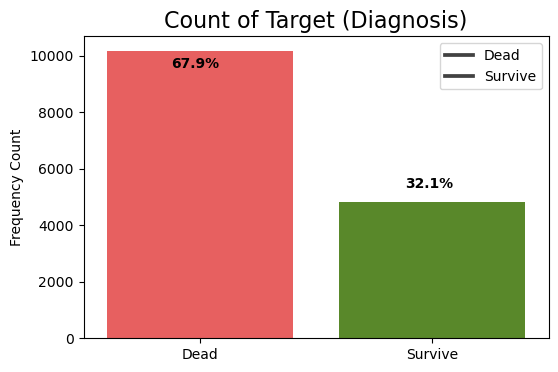

In [26]:
_ = plot_target_distribution(df=df, target=config.target_col,  palette={1: config.target_colors[1], 0: config.target_colors[0]})

### Univariate Predictors Distributions

We can do a univariate plot to show the histogram/kde distribution of these features, we color the hue so that the distribution is parametrized by the target. In addition, we will also perform a box plot to check for potential outliers.

#### Setting Predictor Attributes

In [27]:
predictor_cols = df.columns.to_list()[2:]
set_dataclass_attr(config, "predictor_cols", predictor_cols)
print(f"Predictor Columns: {config.predictor_cols}")

Predictor Columns: ['Gender', 'Smoke', 'Diabetes', 'Age', 'Ejection Fraction', 'Sodium', 'Creatinine', 'Platelets', 'Creatine phosphokinase', 'Blood Pressure', 'Hemoglobin', 'Height', 'Weight', 'Favorite color']


#### Countplots (Categorical)

For categorical features, we can do a simple univariate analysis by plotting countplots with respect to the target variable.

In [28]:
def plot_categorical_univariate(
    df: pd.DataFrame, predictors: str, *args, **kwargs
) -> None:
    """Take in categorical predictors and plot univariate distribution with respect to target.

    Args:
        df (pd.DataFrame): Dataframe.
        predictors (str): Predictor name.
    """

    univariate_params = {
        "nrows": 3,
        "ncols": 2,
        "figsize": (12, 12),
        "dpi": 80,
    }

    fig, axs = plt.subplots(**univariate_params)

    for i, col in enumerate(predictors):
        sns.countplot(
            data=df,
            x=col,
            ax=axs[i % univariate_params["nrows"]][
                i // univariate_params["nrows"]
            ],
            *args,
            **kwargs
        )
    plt.subplots_adjust(hspace=2)
    fig.suptitle(
        "Coronary Categorical Predictors Univariate Distribution",
        y=1.01,
        fontsize="x-large",
    )
    # fig.legend(df[config.target_col].unique())
    fig.tight_layout()
    plt.show()

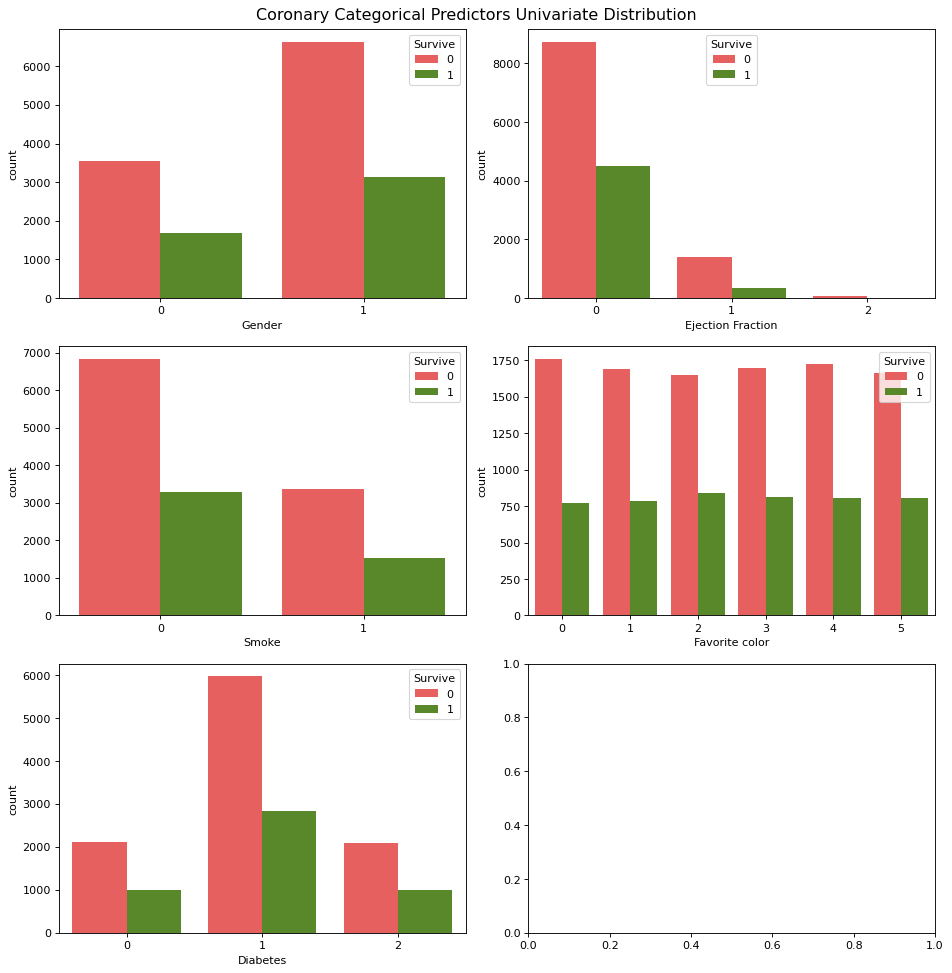

In [29]:
plot_categorical_univariate(
    df,
    predictors=config.categorical_feats,
    hue=config.target_col,
    palette={1: config.target_colors[1], 0: config.target_colors[0]},
)

- The proportion in each is similar to the class distribution. More concretely, as an example, we see that for `Smoke`, the proportion of survive or not is similar whether the patient is a smoker or not. The relative proportion is similar. I did not mention absolute performance here because it can be misleading. For example, one would expect the "death numbers" of smokers to be much higher than those who don't, but in our data, our smokers are much lesser than non-smokers, so naturally we should see more numbers in non-smokers. Though I'd expect some variables like `Smoke` to have a much higher death rate.
- We see that `Ejection Fraction` has extremely low amount of category 2: High. If you really go and see the data, there are around ~1700 of category 1 (normal) and only 60 of category 2 (high). This is quite imbalanced in nature and model might not have sufficient data to learn the 2nd category here. This is something we can take note, whether we want to combine category 2 to category 1 or not. For now, we leave it as it is.

#### Histogram and KDE distribution (Continuous)

We can plot a histogram with KDE for each of the feature, parametrized by the target. The aim of this visual is to briefly see how skewed the features are, whether the features are gaussian, and also the distribution of each feature with respect to the target.

In [30]:
def plot_continuous_univariate(
    df: pd.DataFrame,
    predictors: str,
    univariate_params: Dict[str, Any],
    *args,
    **kwargs,
) -> None:
    """Take in continuous predictors and plot univariate distribution. Note in this setting, we have kde=True.

    Args:
        df (pd.DataFrame): Dataframe.
        predictor (str): Predictor name.
    """

    fig, axs = plt.subplots(**univariate_params)

    for i, col in enumerate(predictors):
        sns.histplot(
            data=df,
            x=col,
            ax=axs[i % univariate_params["nrows"]][
                i // univariate_params["nrows"]
            ],
            *args,
            **kwargs,
        )
    plt.subplots_adjust(hspace=2)
    fig.suptitle(
        "Coronary Continuous Predictors Univariate Distribution",
        y=1.01,
        fontsize="x-large",
    )
    fig.legend(df[config.target_col].unique())
    fig.tight_layout()
    plt.show()

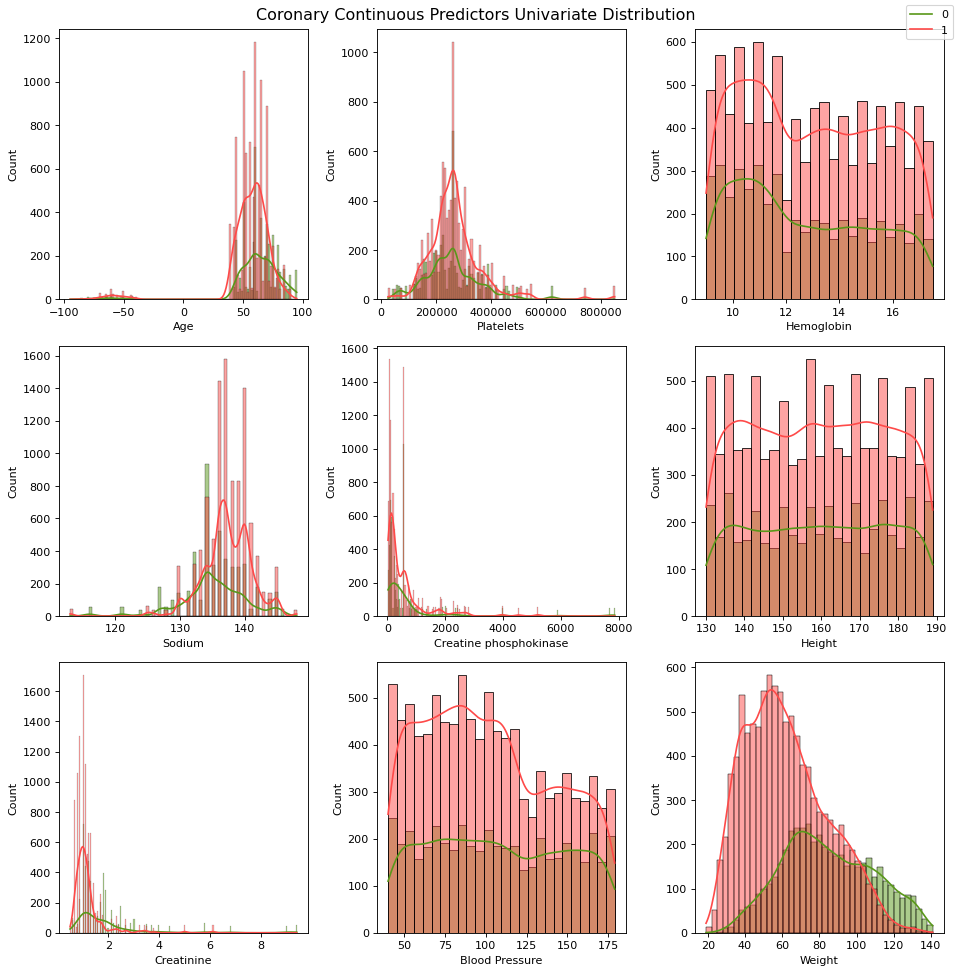

In [31]:
univariate_params = {
    "nrows": 3,
    "ncols": 3,
    "figsize": (12, 12),
    "dpi": 80,
}

_ = plot_continuous_univariate(
    df=df,
    predictors=config.continuous_feats,
    univariate_params=univariate_params,
    kde=True,
    hue=config.target_col,
    legend=False,
    palette={1: config.target_colors[1], 0: config.target_colors[0]},
)

Some variables such as `Height` and `Blood Pressure` look relatively flat and seems like coming from uniform distribution.

#### Box Plots

Although a good alternative to box plots is the violin plot, but we do have the the distribution of KDE earlier on, so we can just zoom in at the box plots to check for outliers. There are some outliers present in the features. 

Briefly, a boxplot shows these metrics:

- Max
- Q3
- Median
- Q1
- Min

> Not much insights can be drawn if one uses boxplot on categorical variables so we just plot on continuous.

---

!!! danger "Outliers Alert!"
    Outliers are tricky, without domain knowledge, it is sometimes hard to tell whether or not an outlier should be removed. A rule of thumb is that if you are sure the outliers are caused by a labelling or human error, then you can remove them. Otherwise, we may need to investigate further to check if these outliers should be retained during modelling.

In [32]:
def plot_univariate_boxplot(
    df: pd.DataFrame, predictors: str, *args, **kwargs
) -> None:
    """Take in continuous predictors and plot univariate boxplot distribution. Note in this setting, we have kde=True.

    Args:
        df (pd.DataFrame): DataFrame.
        predictor (str): Predictor name.
    """

    univariate_params = {
        "nrows": 3,
        "ncols": 3,
        "figsize": (24, 12),
        "dpi": 80,
    }

    fig, axs = plt.subplots(**univariate_params)

    for i, col in enumerate(predictors):
        sns.boxplot(
            data=df,
            x=col,
            ax=axs[i % univariate_params["nrows"]][
                i // univariate_params["nrows"]
            ],
            *args,
            **kwargs
        )
    plt.subplots_adjust(hspace=2)
    fig.suptitle(
        "Coronary Predictors Boxplot Distribution",
        y=1.01,
        fontsize="x-large",
    )
    fig.legend(df[config.target_col].unique())
    fig.tight_layout()
    plt.show()

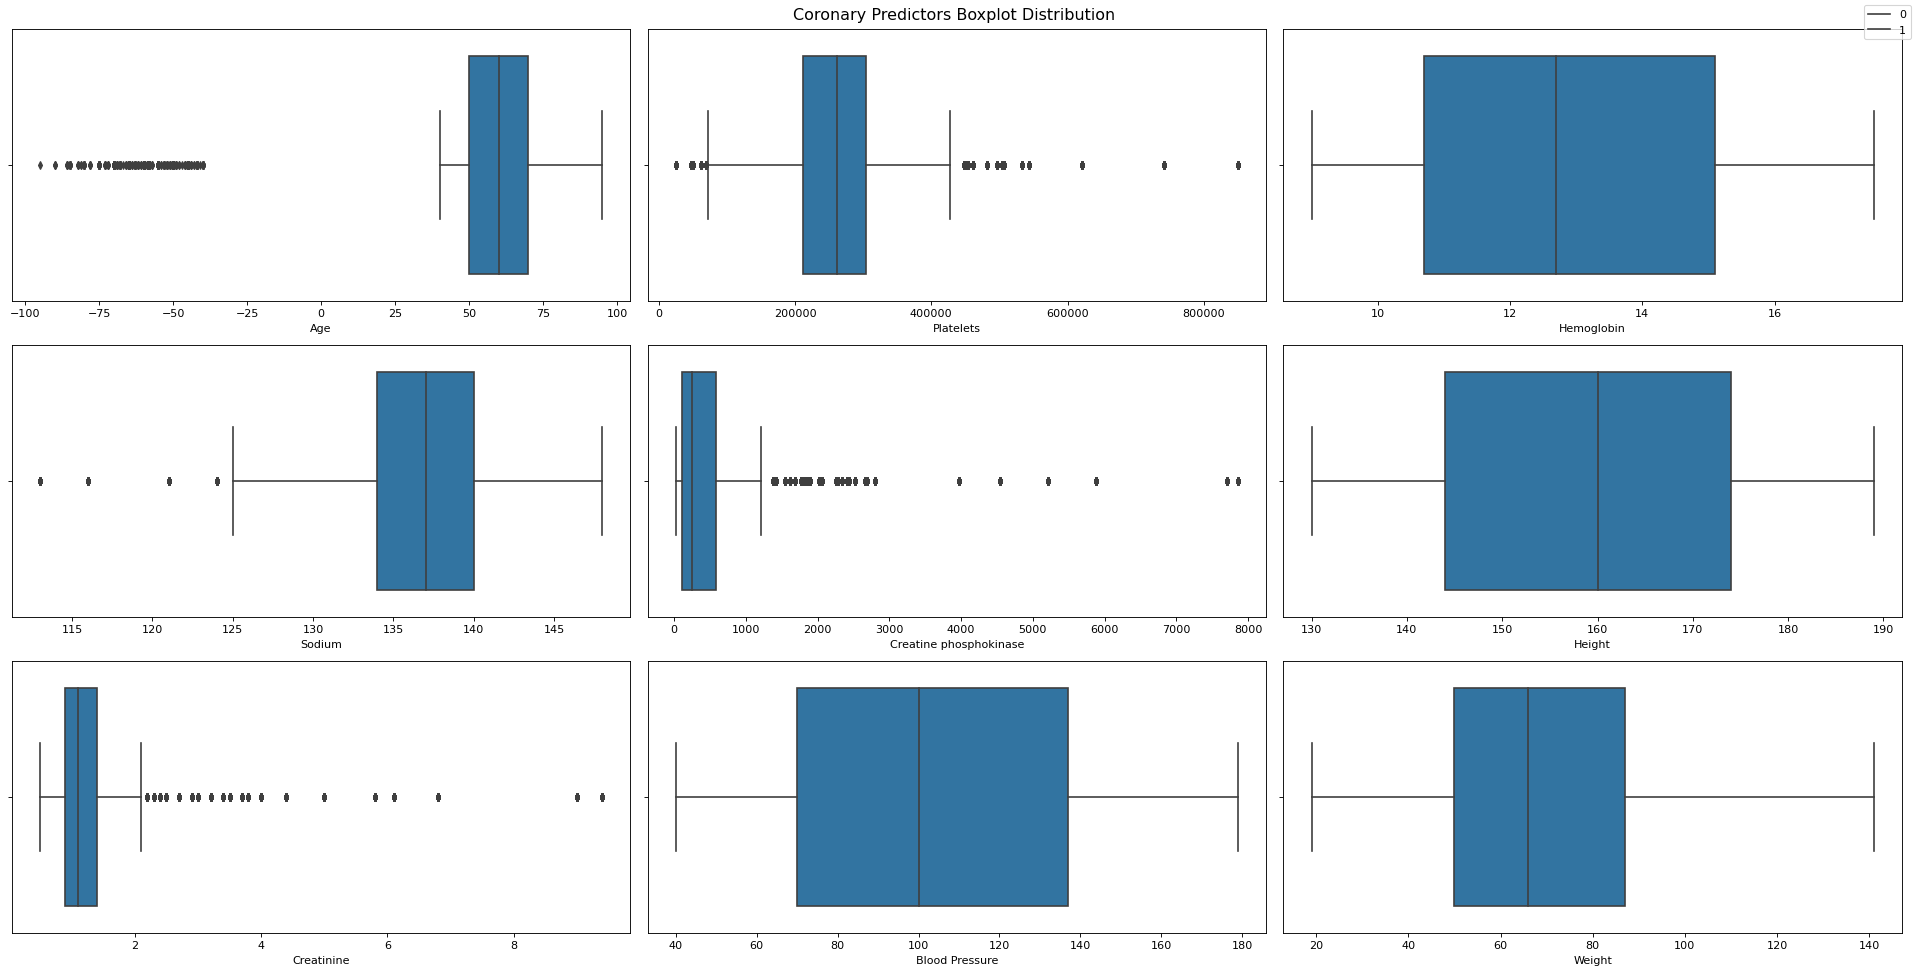

In [33]:
_ = plot_univariate_boxplot(
    df=df, predictors=config.continuous_feats, hue=config.target_col
)

### What did we find: Univariate Insights

From the plots above, we can form very basic hypothesis on the features, we select a few features to explain:
- **Age:** The distribution looks quite normal if we ignore the negative numbers. We can consider imputing or just drop all negative ages.
- **Height, Hemoglobin and Blood Pressure:** The distribution seem quite flat...might be noise. On second thought, does `height` really play a role in one's heart disease? Well `weight` certainly seems to affect.
- **Favorite Color:** The bar plot proved to be quite flat as well, and may be associated with noise.
- Boxplots tell us that there exist some outliers.

---


> In general, the red and green bars (dead vs survive) are not well distinguished if we see it visually; i.e. a lot of overlaps in between the class target distributions and the boundary between targets are not so clear cut. This suggest one individual feature alone may not be pivotal in distinguishing whether a patient survive or not; this makes sense as usually it is a combination of factors that cause a patient's death. for now, seemingly "non-informative" features may become extremely useful when coupled with other features. 

> To see what I mean, we can check the weight distribution, the right tail is mostly "red" which indicates "death", so we can say the right tail is quite "distinguishable" where almost all weight > 120 kg patients died.

## Stage 4 (Part II): Advanced EDA

Now this stage we will correct some issues that we saw in **Stage 3** and plot the distributions along with additional plots.

### Imputing Values

Here we address two issues, the missing values in `Creatine` and negative values in `Age`.

**IMPORTANT NOTE:**

> We are NOT changing the dataframe yet, we are just testing water. If we use a certain method to impute, what happens to the distribution? Let's say we feel **mean imputation** is good and smoothened out the distribution, then we can use it in the `pipeline` later during training to avoid **data leakage**.

---

We will use **Single Mean Imputation** here even though there are some outliers. The good thing about mean imputation is that the sample mean did not change for `Creatinine` but for `Age` it does change.

In [34]:
from sklearn.impute import SimpleImputer
df["Age"] = np.where(df["Age"] <=0, np.nan, df["Age"])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df[["Creatinine", "Age"]].values)

assert df["Creatinine"].mean() == imp.statistics_[0]
assert df["Age"].mean() == imp.statistics_[1]

In [35]:
df["Creatinine"] = df["Creatinine"].fillna(df["Creatinine"].mean())
df["Age"] = df["Age"].fillna(df["Age"].mean())

# df.info()

#### Recheck the Plots

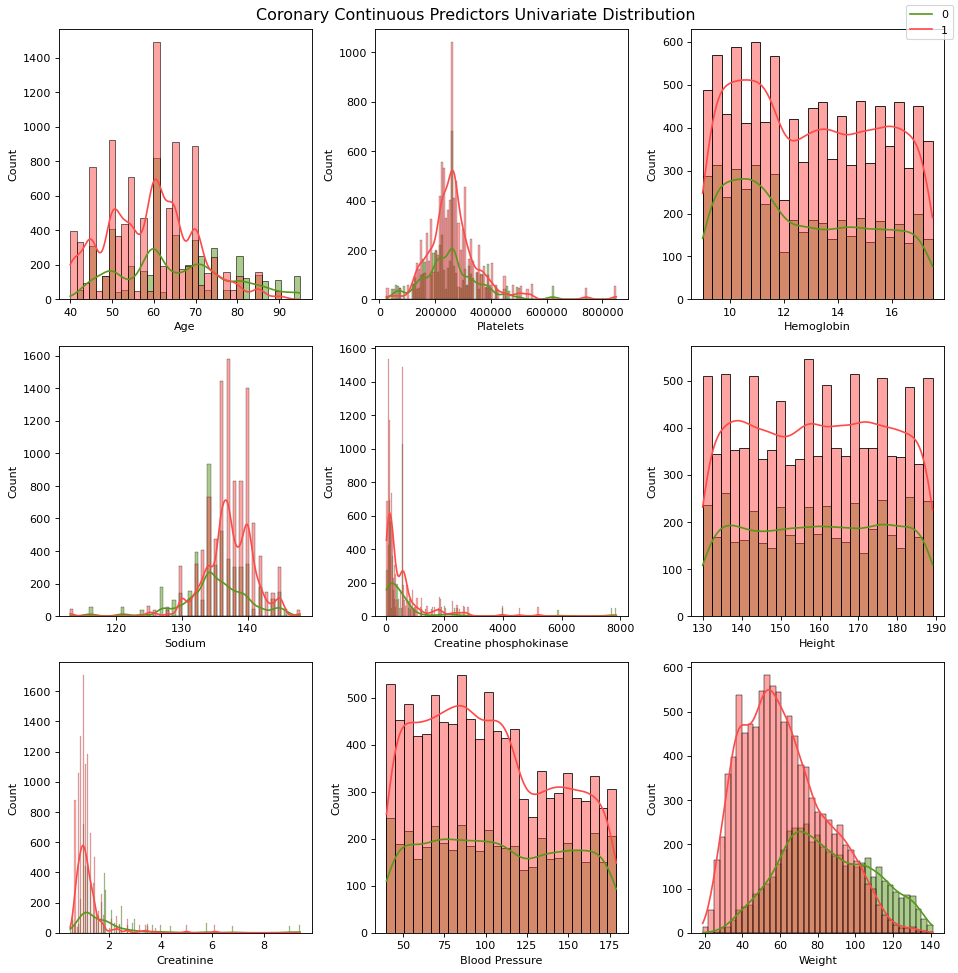

In [36]:
univariate_params = {
    "nrows": 3,
    "ncols": 3,
    "figsize": (12, 12),
    "dpi": 80,
}

_ = plot_continuous_univariate(
    df=df,
    predictors=config.continuous_feats,
    univariate_params=univariate_params,
    kde=True,
    hue=config.target_col,
    legend=False,
    palette={1: config.target_colors[1], 0: config.target_colors[0]},
)

### Correlation Plots

Through the definitions given on the features of the dataset, we know that there are some features that are correlated to each other. From the plots below, multi-collinearity is not really an issue as even though some features appear correlated, it is normal (i.e. height and weight usually moves in one direction).

#### Heatmap

We can plot a simple correlation heatmap to visualize the "hot spots" in which the correlation value is high.

In [37]:
def plot_heatmap(df: pd.DataFrame, predictors: List[str], cmap: str) -> pd.DataFrame:
    """This function takes in a dataframe and a list of predictors, and output the correlation matrix, as well as a plot of heatmap.

    1. Note that annot_kws attempts to make the size of the font visible and contained in the heatmap.
    2. Note that the CMAP is reversed and darker color indicates higher correlation as I find this more intuitive.

    Args:
        df (pd.DataFrame): The dataframe to be plotted.
        predictors (List[str]): The list of predictors to be plotted.

    Returns:
        pd.DataFrame: [description]
    """

    corr = df[predictors].corr()
    annot_kws = {"size": 35 / np.sqrt(len(corr))}

    fig, _ = plt.subplots(figsize=(16, 12))
    sns.heatmap(corr, annot=True, cmap=cmap, annot_kws=annot_kws)
    return corr

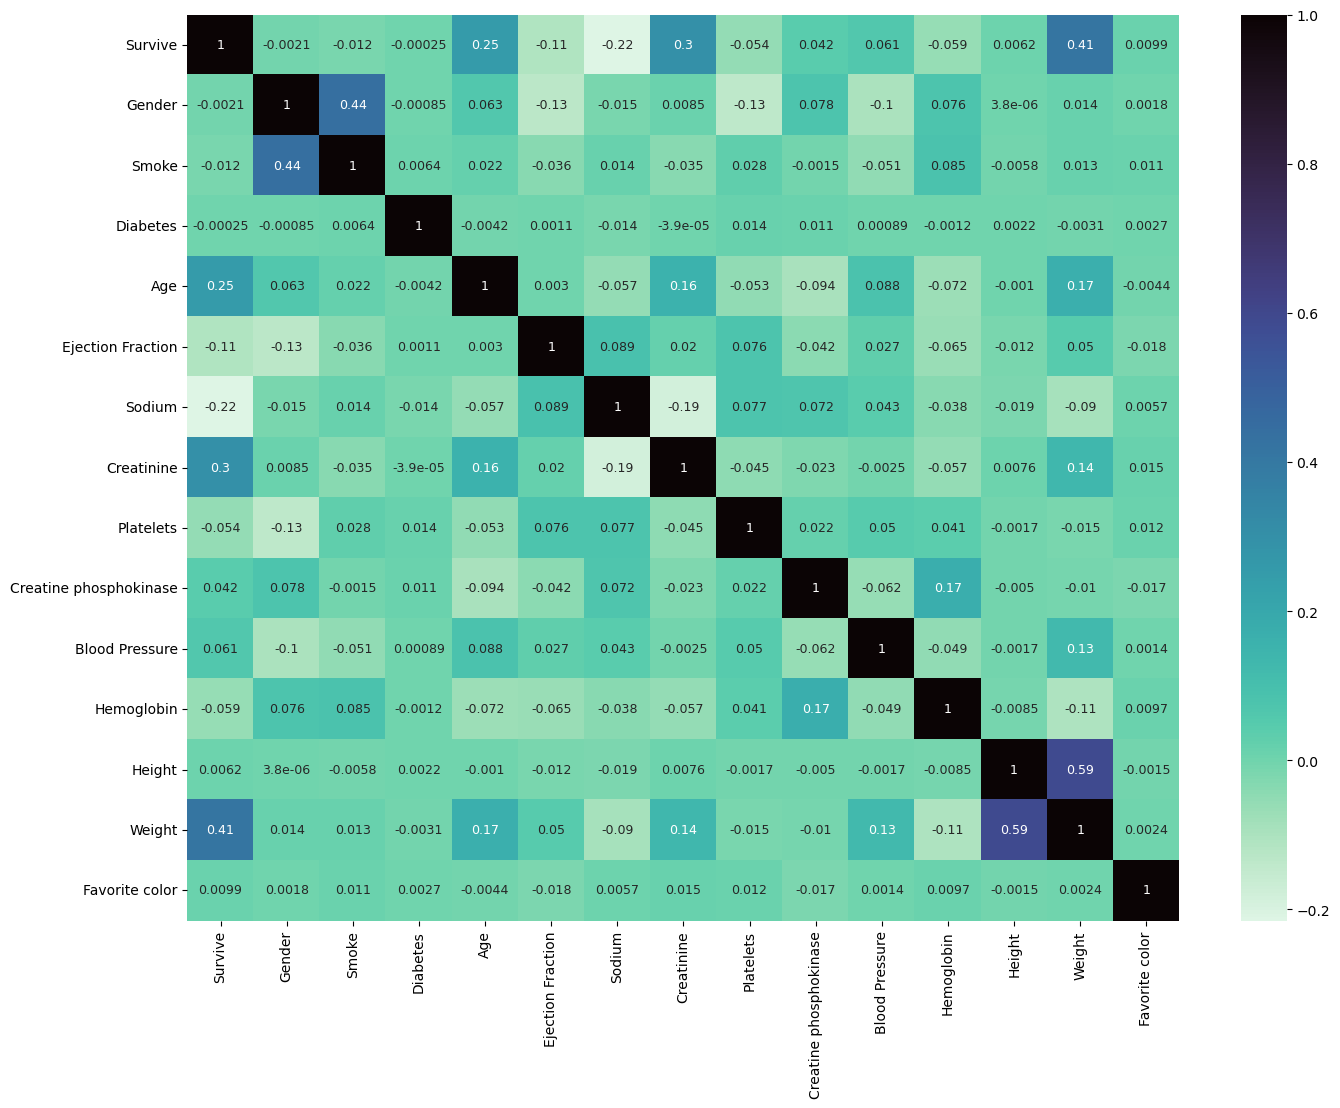

In [38]:
all_columns = df.columns[1:]
corr_matrix = plot_heatmap(df=df, predictors=all_columns, cmap=config.cmap_reversed)

From the correlation plot above, we discovered quite some features being correlated, indicating slight multi-collinearity. We can further strengthen our stance by using a `clusterplot` to check.

#### Cluster Plot

We can use a Hierarchical Clustering to visualize the correlated clusters, the Cluster Map outputs a [Dendrogram](https://www.displayr.com/what-is-dendrogram/) and in our Seaborn plot, we used [Ward's Linkage](https://www.statistics.com/glossary/wards-linkage/#:~:text=Ward%C2%B4s%20linkage%20is,clusters%20into%20a%20single%20cluster.) as our method and the distance metric is Euclidean's Distance. Hence, in the diagram below, the dendrogram implies A and B are more "correlated" than A and C.

<figure>
<img src='https://storage.googleapis.com/reighns/reighns_ml_projects/docs/supervised_learning/classification/breast-cancer-wisconsin/data/images/dendrogram.png' width="500" align="center"/>
<figcaption align = "center"><b>Courtesy of <a href="https://www.displayr.com/what-is-dendrogram/">What is a Dendrogram?</a></b></figcaption>
</figure>

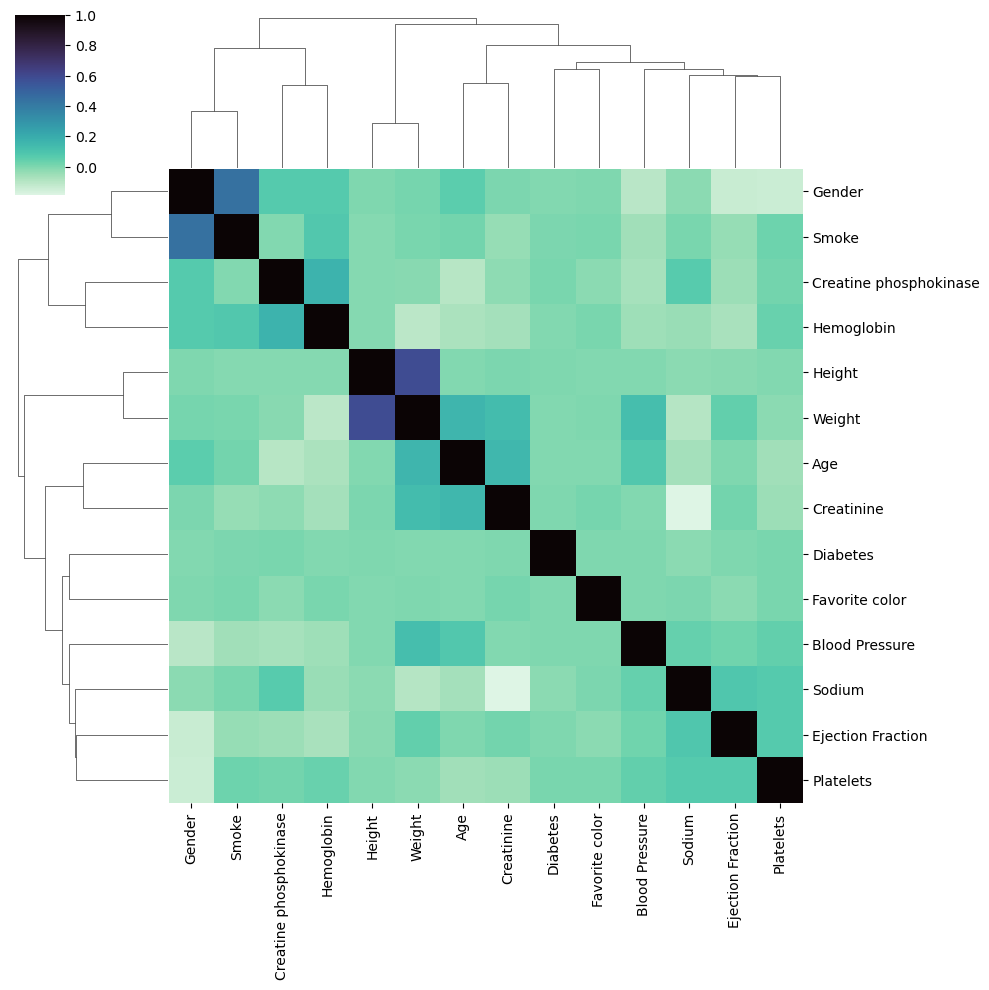

In [39]:
corr = df[config.predictor_cols].corr()
g = sns.clustermap(corr,method="ward",metric='euclidean', cmap=config.cmap_reversed);

### Bivariate Analysis

The plot will have its diagonal conveniently displaying its univariate histogram and kde distribution, while the off-diagonal will show bivariate scatter plots.

In [40]:
def corrfunc(x: np.ndarray, y: np.ndarray, ax=None, **kws) -> None:
    """Plot the correlation coefficient in the top left hand corner of a plot.

    Args:
        x (np.ndarray): x-axis data.
        y (np.ndarray): y-axis data.
        ax ([type], optional): Defaults to None. Axes to plot on.
    """
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f"{r:.1f}", xy=(0.7, 0.15), xycoords=ax.transAxes)

Sorry for the clutter..

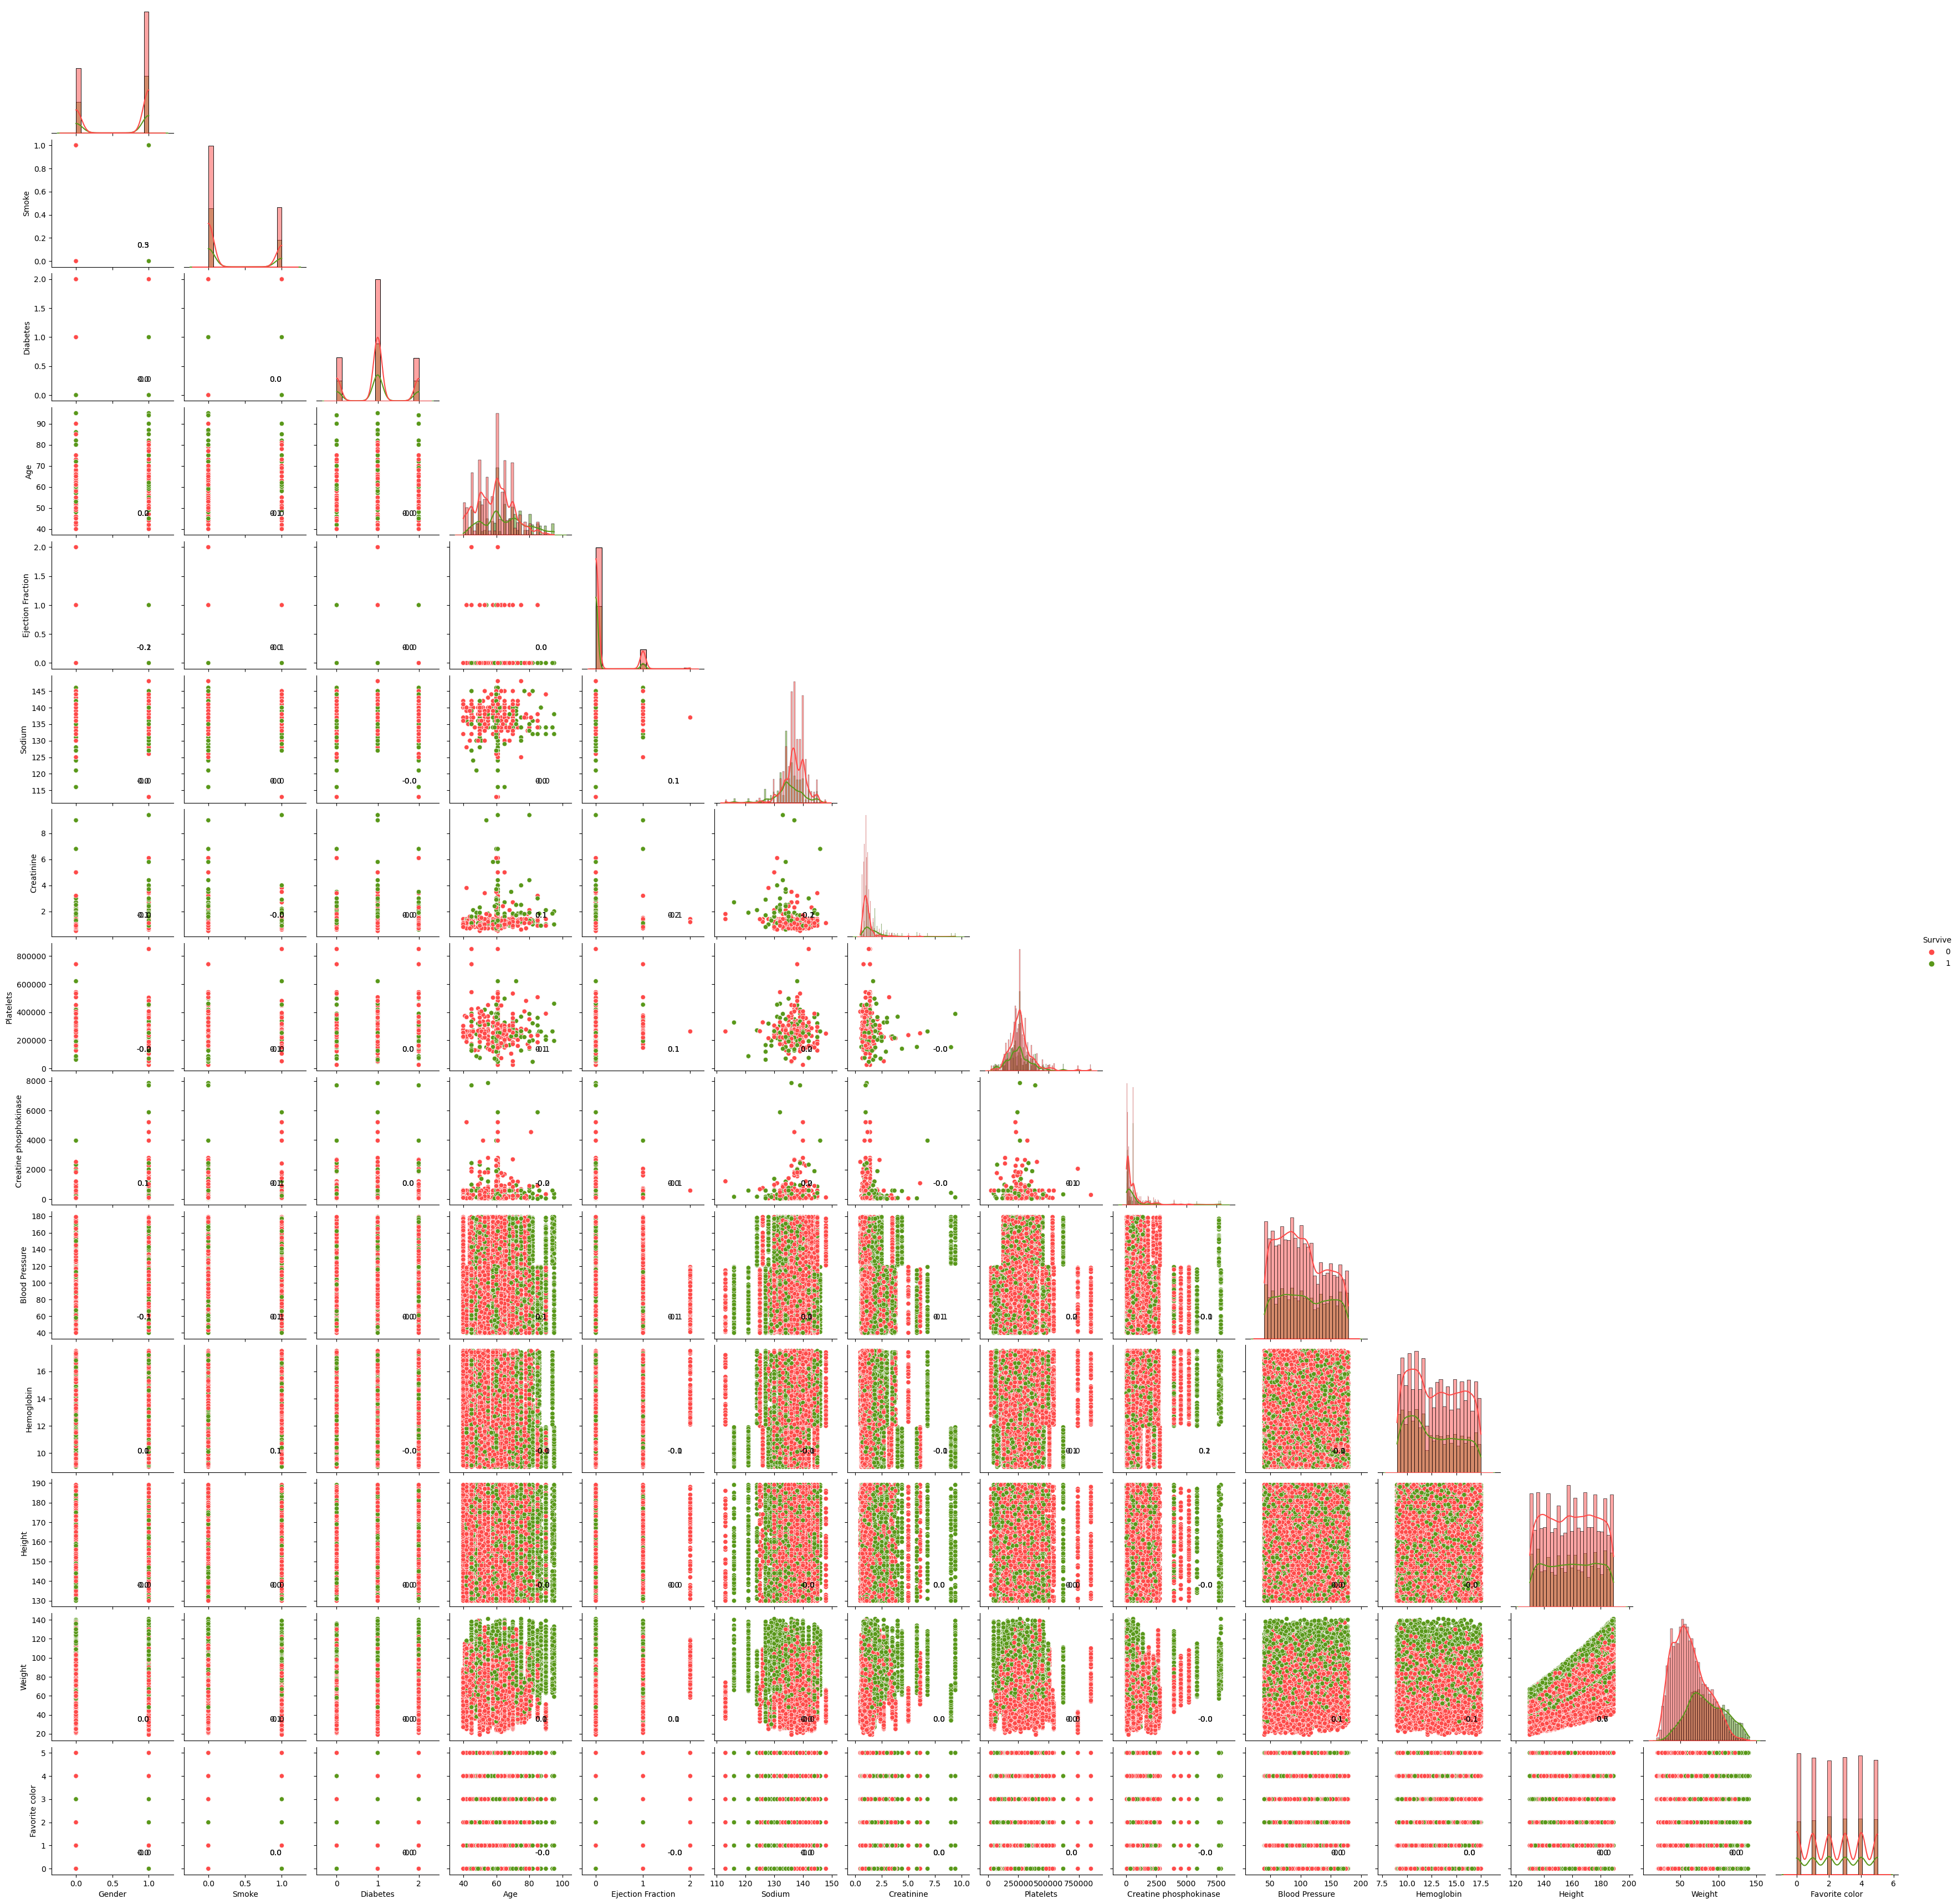

In [41]:
pp_mean = sns.pairplot(
    df,
    hue=config.target_col,
    vars=config.predictor_cols,
    palette={1: config.target_colors[1], 0: config.target_colors[0]},
    diag_kind="auto",
    corner=True,
)

pp_mean = pp_mean.map_offdiag(sns.scatterplot)
pp_mean = pp_mean.map_diag(sns.histplot, kde=True)
pp_mean = pp_mean.map_lower(corrfunc)

## Step 5: Feature Engineering and Preprocessing

### Foreword on Data Leakage and Preprocessing Methodology (Important)

We are fully aware that oftentimes practitioner may accidentally cause data leakage during preprocessing, for example, a subtle yet often mistake is to **standardize/scale** the whole dataset prior to splitting into `train` and `test`, or performing **feature selection** prior to modelling using the information of our **response/target variable**. 

However, this does not mean we should not do any preprocessing before modelling, instead, we can have the following methodology:

- **Feature Scaling:** In our Stage 1 and 2 data cleaning/inspection, we will have a good idea whether our features are on the same scale or not. In general, algorithms such as KNN which uses some form of distance metrics will be gravely affected by variables on largely different scales. See here[^when_should_one_scale_data].
    - This should be done after splitting to avoid data leakage.
- **Imputation:** In Stage 1 and 2, we are able to see whether data has missing or unreasonable values, if so, we can make use of EDA to give us informed decision on **which method to use for imputation**.
    - This should be done after splitting to avoid data leakage.
- **Encoding:** In Stage 1, we can already know what are some categorical variables that require encoding.
    - This can be done before the splitting and hence on the entire dataset. See here[^encoding_and_data_leakage].
- **Outliers:** In Stage 1 and 2, our EDA will suffice in telling us about the outliers of the dataset.
- **Multi-collinearity:** In Stage 2, we can screen predictors for multicollinearity during EDA phase and have a good intuition on which predictors are highly correlate; subsequently, we will incorporate feature selection techniques in our modelling pipeline to remove highly correlated features, if necessary.
    - Feature Selection should be done after splitting to avoid data leakage.
- **Feature Transforms:**
    - **Dropping unwanted columns:** This can be done before splitting.
    - **Binning:** We can bin variables if necessary. To me this can be done after splitting.
    - **Feature Combination:** Add or create new features from existing features.
    
    
[^when_should_one_scale_data]: https://www.thekerneltrip.com/statistics/when-scale-my-data/
[^encoding_and_data_leakage]: https://datascience.stackexchange.com/questions/78146/does-label-encoding-an-entire-dataset-cause-data-leakage

### References on Feature Engineering

- [When should one scale data?](https://www.thekerneltrip.com/statistics/when-scale-my-data/)
- [Encoding and Data Leakage](https://datascience.stackexchange.com/questions/78146/does-label-encoding-an-entire-dataset-cause-data-leakage)
